In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm
from matplotlib import pyplot as plt
from scipy.optimize import minimize

In [3]:
suffix = ".xlsx"
prefix = "DataLab3"

ppath = prefix + "prices" + suffix
apath = prefix + "accounting" + suffix
rpath = prefix + "rf" + suffix

In [4]:
p_df = pd.read_excel(ppath)
a_df = pd.read_excel(apath)
r_df = pd.read_excel(rpath)

In [5]:
def my_merton(x,sige,E,d,rf,t):
    d1 = (np.log(x[1]/d)+(rf+0.5*x[0]**2)*t)/(x[0]*np.sqrt(t))
    d2 = d1-x[0]*np.sqrt(t)
    
    f1 = x[1]*norm.cdf(d1)-np.exp(-rf*t)*d*norm.cdf(d2)-E # This is the equation on slide 21 Video L13 
    f2 = (x[1]/E)*norm.cdf(d1)*x[0]-sige # This is the equation on slide 22 Video L13 
    
    return np.sqrt(f1**2+f2**2) # Minimize f over x(1) and x(2) solves for Equity vol and Asset value

In [6]:
equityReturns = np.log(p_df.Prices/p_df.Prices.shift(1))
equityReturns = equityReturns[1:-1] 

sige = stats.tstd(equityReturns)*np.sqrt(250) 
E = a_df.CSHO*p_df.Prices.iloc[-1] 

rf = np.mean(r_df.Riskfree) # Risk free rate as average of monthly rates
t = 1 # We want PD in 1 year
PDs = []

for k in np.arange(0.1,1,0.1):
    K = a_df.LCT+k*a_df.DLTT # all short term + k of long term
    x0=(sige,K[0]+E[0])
    res = minimize(my_merton, x0, method='BFGS',
                   args=(sige,E[0],K[0],rf,t), options={'disp': False},
                  )
    DD = (np.log(res.x[1])+(rf-0.5*res.x[0]**2)*np.sqrt(t)-np.log(K))/(res.x[0]*np.sqrt(t))
    PDs.append(float(norm.cdf(-DD)))

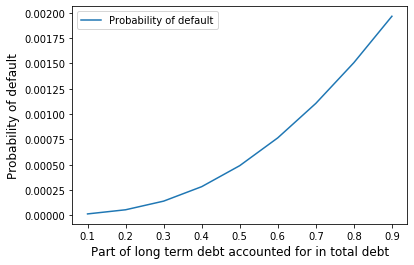

In [7]:
fig,ax=plt.subplots(nrows=1,ncols=1)

ax.plot(np.arange(0.1,1,0.1),PDs,label='Probability of default')

plt.xlabel('Part of long term debt accounted for in total debt',fontsize=12)
plt.ylabel('Probability of default',fontsize=12)
plt.legend();

In [23]:
p_df['date'] = pd.to_datetime(p_df.Date, format= '%Y%m%d')
last_date = p_df.date.iloc[-1]

In [37]:
PDs = []
volatilities = []
for i in range(0,12):
    prices_in_interval = p_df[(p_df.date.dt.month >= last_date.month-i) & (p_df.date.dt.year == last_date.year)]
    #equityReturns = prices_in_interval.Prices/prices_in_interval.Prices.shift(1)
    equityReturns = np.log(prices_in_interval.Prices/prices_in_interval.Prices.shift(1))
    equityReturns = equityReturns[1:-1] 

    sige = stats.tstd(equityReturns)*np.sqrt(250) # not len(prices_in_interval)? 
    volatilities.append(sige)
    E = a_df.CSHO*p_df.Prices.iloc[-1] 

    rf = np.mean(r_df.Riskfree)
    t = 1 
    k = 0.5
    K = a_df.LCT+k*a_df.DLTT # all short term + k of long term
    x0=(sige,K[0]+E[0])
    
    res = minimize(my_merton, x0, method='BFGS',
                   args=(sige,E[0],K[0],rf,t), options={'disp': False},
                  )
    DD = (np.log(res.x[1])+(rf-0.5*res.x[0]**2)*np.sqrt(t)-np.log(K))/(res.x[0]*np.sqrt(t))
    PDs.append(float(norm.cdf(-DD)))

In [31]:
# Using an EWMA estimate for the volatility 

equity_returns = np.log(p_df.Prices/p_df.Prices.shift(1))[1:-1]
lambda_ = 0.94
es = [0]
es[1:] = list(equity_returns)
es2 = np.power(es,2)
sigmas2 = [np.var(equity_returns)]

for i in range(0,len(equity_returns)):
    sigt = (1-lambda_)*es2[i] + lambda_*sigmas2[i]
    sigmas2.append(sigt)

volatility_estimate = np.mean(np.sqrt(sigmas2))

In [32]:
sige = volatility_estimate*np.sqrt(250)
E = a_df.CSHO*p_df.Prices.iloc[-1] 
rf = np.mean(r_df.Riskfree) # Risk free rate as average of monthly rates
t = 1 # We want PD in 1 year

k = 0.5
K = a_df.LCT+k*a_df.DLTT # all short term + k of long term

x0=(sige,K[0]+E[0])
res = minimize(my_merton, x0, method='BFGS',
               args=(sige,E[0],K[0],rf,t), options={'disp': False},
              )
DD = (np.log(res.x[1])+(rf-0.5*res.x[0]**2)*np.sqrt(t)-np.log(K))/(res.x[0]*np.sqrt(t))
PD_ewma = float(norm.cdf(-DD))

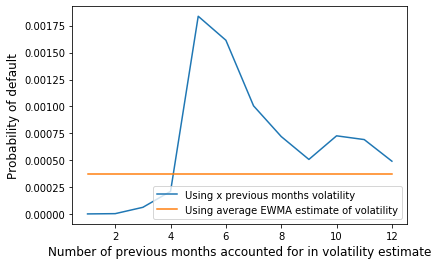

In [33]:
fig,ax=plt.subplots(nrows=1,ncols=1)

ax.plot(np.arange(1,13,1), PDs,label='Using x previous months volatility')
ax.plot(np.arange(1,13,1),PD_ewma*np.ones(12), label = 'Using average EWMA estimate of volatility')

plt.xlabel('Number of previous months accounted for in volatility estimate',fontsize=12)
plt.ylabel('Probability of default',fontsize=12)
plt.legend();

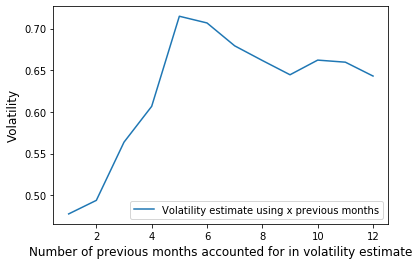

In [39]:
fig,ax=plt.subplots(nrows=1,ncols=1)

ax.plot(np.arange(1,13,1), volatilities,label='Volatility estimate using x previous months')

plt.xlabel('Number of previous months accounted for in volatility estimate',fontsize=12)
plt.ylabel('Volatility',fontsize=12)
plt.legend();

## a) Which input is the Merton models most sensitive to?
We see that the overall highest estimated probability (~2‰) of default comes from when we incorporate 90% of the long term debt into the total debt. It is not very surprising that the probability grows monotonic when we account for more debt. If we instead compare with the change in volatility estimate, we see that this does not behave as regulary. This comes from the fact that the volatility estimate itself varies up and down depending on what months we incorporate. The highest volatility estimate results in the highest probability of default. Below is a plot that shows the model's sensitivity to different volatility inputs, between 0.1 and 0.9. This shows that for volatilies above 0.6, the PD rises fast and takes a maximum at PD ≈ 1.6%, almost eight times larger than the highest PD from when varying the amount of debt. However, one should note that a log equity return volatility of 0.9 is very high, although the last five months of the year actually did reach a volatility > 0.7, as seen in the the third figure.

Conclusion:
Since the PD is very sensitive to volatility inputs larger than 0.6, and the volatility estimates actually go from around 0.6 to above 0.7 when just incorporating one more month in the period, I conclude that the model is most sensitive to volatility input.

## b) Given the sensitivity, do you think the Merton model is a useful model for risk management?
I think that the model is useful because of the sensitivity. The final probability of default is a composite model where many numbers are taken into account, and the final model will not be much better than its individual components. Therefore, it is vital to use good predictions of volatilty and debt, and of course the PD should vary with these estimates. A good use of the model is to find an interval of PD that is acceptable to stakeholders, and find boundaries for debt and volatility values that maintain this PD. If breaches are made, changes need to be done. A suitable quote to end this exercise with is from british statistician George Box: "*All models are wrong, but some are useful*".


In [42]:
equityReturns = np.log(p_df.Prices/p_df.Prices.shift(1))
equityReturns = equityReturns[1:-1] 

siges = np.arange(0.1,1,0.1)
E = a_df.CSHO*p_df.Prices.iloc[-1] 

rf = np.mean(r_df.Riskfree) # Risk free rate as average of monthly rates
t = 1 # We want PD in 1 year
PDs = []

for volatility in siges:
    K = a_df.LCT+k*a_df.DLTT # all short term + k of long term
    x0=(volatility,K[0]+E[0])
    res = minimize(my_merton, x0, method='BFGS',
                   args=(volatility,E[0],K[0],rf,t), options={'disp': False},
                  )
    DD = (np.log(res.x[1])+(rf-0.5*res.x[0]**2)*np.sqrt(t)-np.log(K))/(res.x[0]*np.sqrt(t))
    PDs.append(float(norm.cdf(-DD)))

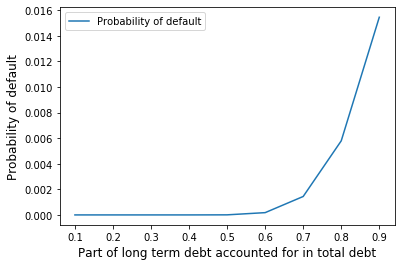

In [43]:
fig,ax=plt.subplots(nrows=1,ncols=1)

ax.plot(np.arange(0.1,1,0.1),PDs,label='Probability of default')

plt.xlabel('Part of long term debt accounted for in total debt',fontsize=12)
plt.ylabel('Probability of default',fontsize=12)
plt.legend();